In [60]:
import Pkg
Pkg.activate("MD_simulation/")
using Plots, Parameters, LaTeXStrings, Test, Printf, ProgressMeter

  Activating project at `~/Insync/viniciuspiccoli2008@hotmail.com/OneDrive/Programing_Projects/FQ_topics/MD_simulation`


## Notebook for concepts of thermodynamics, statistical mechanics and liquids simulations

In this notebook several concepts important for liquids simulations will be reviewed with examples of a LJ fluid. These systems are easier to program a MD code from scratch, which is the main porpouse of this file. Also, several aspects will be evaluate concerning thermodynamics and statistical mechanics. all the content will be based on: computer simulation of liquids - M. P Allen; https://dpotoyan.github.io/Statmech4ChemBio/1_stats/Probabilities_Counting.html, and books like Physical Chemistry from Levine, chemistry3, etc.

* books like: Computational Physics  Problem Solving with Computers and LEARNING ALGORITHMS  THROUGH  PROGRAMMING AND PUZZLE SOLVING will also be used to improve the code. Concepts with these books are applied to any programming language. Here, Julia will be used.

* Links will be provided throughout the file, that will indicate more contect to be read. 

* The main idea of this is for myself: improve my knowleged, learn more advanced concepts and have a good material for reviewing!

One of the most important (actually initial) aspects of a MD simulation is related to the potential calculation. The Lennard-Jones potential approximates the potential energy of non-electrostatic interaction betyween a pair of non-bonded atoms or molecules. The equation that describes this potential is given by:

$$
V(r) = 4\varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right]
$$

Where:
- $V(r)$ = potential energy between two particles
- $\varepsilon$ = depth of the potential well (measure of strength)
- $\sigma$ = finite distance at which interparticle potential is zero
-  $r$ = distance between particles

The $(1/r)^{12}$ term represents repulsive forces and the $(1/r)^6$ term represents attractive forces.




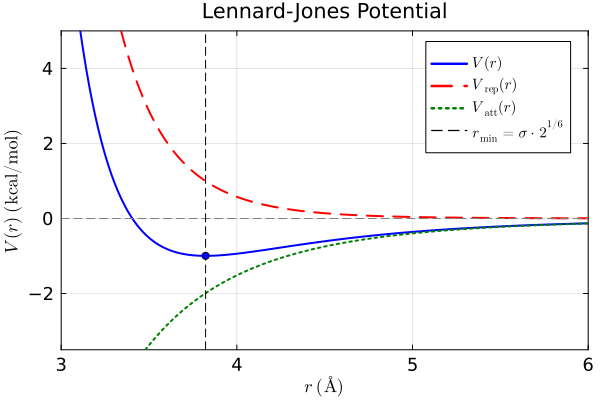

In [3]:
using Plots, LaTeXStrings

# Set the GR backend (best for Jupyter)
gr()

# Lennard-Jones potential functions
V(r; ϵ=0.996, σ=3.405)    = 4ϵ*((σ/r)^12 - (σ/r)^6)
V_repulsive(r; ϵ=0.996, σ=3.405) = 4ϵ*(σ/r)^12  # Corrected label
V_attractive(r; ϵ=0.996, σ=3.405) = -4ϵ*(σ/r)^6  # Corrected label

# Define range for r, avoiding division by zero
x = range(2.5, 10, length=4000)

# Compute function values
V_values = V.(x)
Vrep_values = V_repulsive.(x)
Vatt_values = V_attractive.(x)

# Create the plot with corrected labels and focused view
plt = plot(
    x, V_values, 
    label=L"V(r)", color=:blue, linewidth=2, legend=:topright,
    xlims=(3, 6), ylims=(-3.5, 5),  # Focused axis ranges
    xlabel=L"r \ (\textrm{\AA})", ylabel=L"V(r) \ (\textrm{kcal/mol})",
    title="Lennard-Jones Potential",
    size=(600, 400),
    legendfontsize=10, tickfontsize=12, titlefontsize=14, labelfontsize=12, framestyle=:box
)

plot!(
    x, Vrep_values, 
    label=L"V_{\textrm{rep}}(r)", color=:red, linestyle=:dash, linewidth=2  # Corrected label
)

plot!(
    x, Vatt_values, 
    label=L"V_{\textrm{att}}(r)", color=:green, linestyle=:dot, linewidth=2  # Corrected label
)

hline!([0], color=:gray, linestyle=:dash, linewidth=1, label=false)
vline!([3.405*2^(1/6)], color=:black, linestyle=:dash, linewidth=1, 
      label=L"r_{\textrm{min}} = \sigma \cdot 2^{1/6}")

# Highlight potential minimum
scatter!([3.405*2^(1/6)], [-0.996], color=:blue, markersize=4, label=false)

# Display the plot
display(plt)

In [61]:
# lets define a data structure for the atoms

#= Reduced LJ Units Reference (Argon example):
σ (distance) = 3.4 Å (LJ diameter)
ε (energy) = 0.238 kcal/mol (LJ well depth)
mass = 39.948 amu (argon atomic mass)
=#

struct UnitSystem
    σ_ref :: Float64    # Reference σ in Å (conversion to reduced units)
    ε_ref :: Float64    # Reference ε in kcal/mol
    mass_ref :: Float64 # Reference mass in amu
end

# Example unit system using Argon parameters
const argon_units = UnitSystem(3.4, 0.238, 39.948)

UnitSystem(3.4, 0.238, 39.948)

In [ ]:

# structure to define static parameters
@with_kw struct AtomID
    # Real unit parameters (user input)
    name :: String
    σ_real :: Float64    # Å
    ε_real :: Float64    # kcal/mol
    mass_real :: Float64 # amu
    
 # Unit system reference
    unit_system::UnitSystem = argon_units  # Add this line

    # Reduced units (calculated using reference)
    σ :: Float64 = σ_real / argon_units.σ_ref
    ε :: Float64 = ε_real / argon_units.ε_ref
    mass :: Float64 = mass_real / argon_units.mass_ref
    
    # Precomputed LJ parameters
    σ6 :: Float64 = σ^6
    σ12 :: Float64 = σ^6^2
    ε4 :: Float64 = 4.0 * ε
end

# inputs for the MD simulations with static parameters
@with_kw struct MDinput
    # Real units (user input)
    temp_real :: Float64 = 298.15      # K
    box_size :: Vector{Float64}        # Å
    total_time_real :: Float64 = 10.0  # ps
    dt_real :: Float64 = 0.001         # ps
    
    # Reduced units (calculated)
    temp :: Float64 = temp_real * (argon_units.ε_ref / 0.0083144621)  # Convert K to ε/kB
    box :: Vector{Float64} = box_size ./ argon_units.σ_ref
    dt :: Float64 = dt_real / (argon_units.σ_ref * sqrt(argon_units.mass_ref/argon_units.ε_ref))
    nsteps :: Int = trunc(Int, total_time_real/dt_real)
end



@with_kw mutable struct AtomState
    id::AtomID          # Static parameters
    r::Vector{Float64}  # Position (reduced units)
    v::Vector{Float64}  # Velocity (reduced units)
    f::Vector{Float64}  # Force (reduced units)
    f_prev::Vector{Float64} = zeros(length(r))  # Previous force for Verlet
end


@with_kw mutable struct Simulation
    atoms::Vector{AtomState}
    input::MDinput
    current_step::Int = 0
    time::Float64 = 0.0
    trajectory::Vector{Vector{Tuple{String,Vector{Float64}}}} = []
    log_interval::Int = 100
end


ErrorException: invalid redefinition of constant Main.Simulation

In [64]:
function setRectangular(input::MDinput, atoms::Vector{AtomID}, dims::Vector{Int}; noise=0.1)
    positions = []
    n_dim = length(input.box)
    spacing = input.box ./ dims
    
    particle = 1
    for i in CartesianIndices(Tuple(dims))
        pos = [spacing[d] * (i[d] - 0.5) for d in 1:n_dim]
        
        # Add noise if requested
        if noise > 0
            pos .+= noise .* randn(n_dim)
        end
        
        # Cycle through atom types
        push!(positions, (pos, atoms[mod1(particle, length(atoms))]))
        particle += 1
    end
    
    return positions
end

setRectangular (generic function with 2 methods)

In [65]:
#=
We canm therefore, create a fyunction to calculate the potential energy of lj particles interacting with each other.
=#

```
Function to calculate the potential energy between pairs
```
function pair_lj(pos1, atom1::AtomID, pos2, atom2::AtomID)
    dr = sqrt(sum((pos1 .- pos2).^2))
    if dr == 0 
        return 0.0 
    end  # Skip self-interaction
    
    # Lorentz-Berthelot mixing rules
    σ_mix = (atom1.σ + atom2.σ)/2
    ε_mix = sqrt(atom1.ε * atom2.ε)
    
    σ6 = (σ_mix)^6
    σ12 = σ6^2
    inv_r6 = (1/dr)^6
    inv_r12 = inv_r6^2
    
    return 4.0 * ε_mix * (σ12 * inv_r12 - σ6 * inv_r6)
end

# ε/ε_ref - ε: kcal/mol
function total_lj(positions)
    energy = 0.0
    n = length(positions)
    
    for i in 1:n
        (pos_i, atom_i) = positions[i]
        for j in (i+1):n
            (pos_j, atom_j) = positions[j]
            energy += pair_lj(pos_i, atom_i, pos_j, atom_j)
        end
    end
    
    return energy
end


total_lj (generic function with 2 methods)

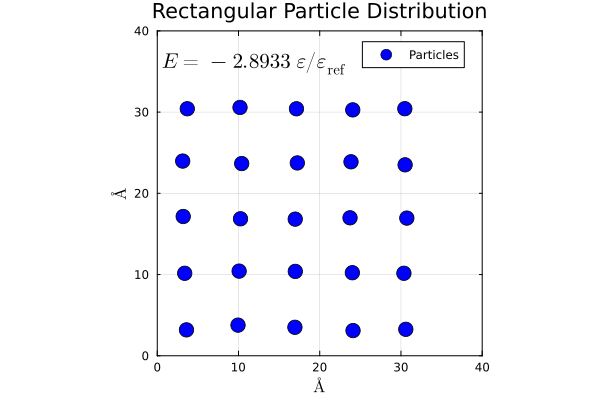

In [66]:
# Define atom types
ar = AtomID(name="Ar", σ_real=3.4, ε_real=0.238, mass_real=39.948)
#he = AtomID(name="He", σ_real=2.64, ε_real=0.083, mass_real=4.0026)

# Set up MD parameters
md = MDinput(
    box_size=[34.0, 34.0],  # 10σ in each dimension
    temp_real=300.0,
    total_time_real=10.0,
    dt_real=0.001
)

# Create initial configuration
#positions = setRectangular(md, [ar, he], [5, 5], noise=0.05)
positions = setRectangular(md, [ar], [5, 5], noise=0.05)

# Calculate initial energy
energy = round(total_lj(positions), digits=4)

x = [pos[1] * argon_units.σ_ref for (pos, atom) in positions]
y = [pos[2] * argon_units.σ_ref for (pos, atom) in positions]


# Create the plot
scatter(x, y,
    label = "Particles",
    title = "Rectangular Particle Distribution",
    xlabel = L"\textrm{\AA}",
    ylabel = L"\textrm{\AA}",
    aspect_ratio = :equal,  # Keep axis scales equal
    markersize = 8,
    markercolor = :blue,
    xlims = (0, 40),
    ylims = (0, 40),
    framestyle=:box

)
annotate!(12, 36, text(L"E = %$(energy)\ \textrm{\epsilon / \epsilon_{ref}}")) 




# Periodic boundary conditions

An important aspects of all computational simulations is the periodic boundary conditions. 

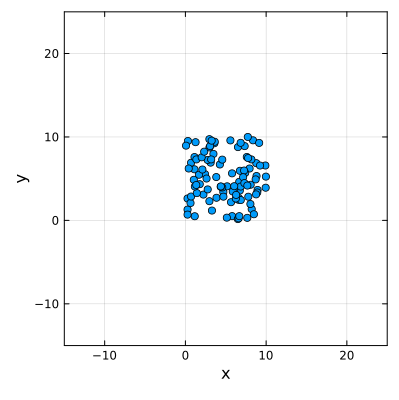

In [8]:

p = [ 10*rand(2) for i in 1:100 ]
x = [ p[i][1] for i in 1:100 ]
y = [ p[i][2] for i in 1:100 ]
scatter(x,y,
xlabel="x",ylabel="y",label="",
xlim=[-15,25],ylim=[-15,25],
size=(400,400),framestyle=:box)


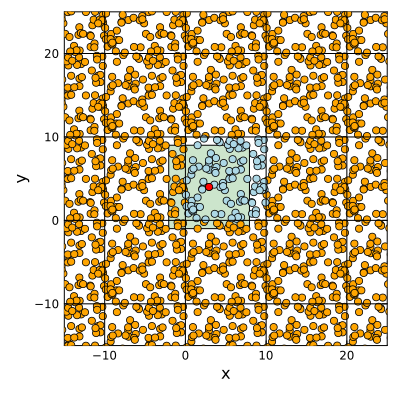

In [9]:
function square(c,side)
    x = [ c[1]-side/2, c[1]+side/2, c[1]+side/2, c[1]-side/2, c[1]-side/2]  
    y = [ c[2]-side/2, c[2]-side/2, c[2]+side/2, c[2]+side/2, c[2]-side/2]
    return x, y
  end
  
  # Generate points
  p = [ 10*rand(2) for i in 1:100 ]
  
  # Plot a square around point 1
  plot(square(p[1],10),seriestype=[:shape],
              linewdith=0.5,fillalpha=0.2,
              color="green",label="")
  
  # Images
  images = [ -2, -1, 0, 1, 2 ]
  for j in images, k in images
    if j != 0 || k != 0 # Do not plot (0,0) again
      xim = [ p[i][1] + j*10 for i in 1:100 ]
      yim = [ p[i][2] + k*10 for i in 1:100 ]
      scatter!(xim,yim,color="orange",label="")
    end
  end
  
  # Central plot
  x = [ p[i][1] for i in 1:100 ]
  y = [ p[i][2] for i in 1:100 ]
  scatter!(x,y,xlabel="x",ylabel="y",label="",color="lightblue")
  
  # Mark point one as red
  scatter!([p[1][1]],[p[1][2]],color="red",label="",size=4)
  
  plot!(xlim=[-15,25],ylim=[-15,25],
        size=(400,400),framestyle=:box)
  
  hline!(10*images,color="black",label="") # horizontal lines
  vline!(10*images,color="black",label="") # vertical lines

In [67]:
function minimum_image(rx, L)
    if rx >= L/2
        rx -= L
    elseif rx < -L/2
        rx += L
    end
    return rx
end

# IF 2d particles [rx, ry] // [box_x, box_y]
function apply_minimum_image!(dr, box)
    for d in eachindex(dr)
        dr[d] = minimum_image(dr[d], box[d])
    end
    return dr
end


apply_minimum_image! (generic function with 1 method)

In [68]:
# tests
# Test 1: Simple wrap
L = 10.0
@assert minimum_image(7.0, L) ≈ -3.0  # 7 → 7-10 = -3
@assert minimum_image(-6.0, L) ≈ 4.0  # -6 → -6+10 = 4

# Test 2: Edge cases
@assert minimum_image(5.0, 10.0) ≈ -5.0  # Exact half-box
@assert minimum_image(-5.0, 10.0) ≈ -5.0  # Maintains sign convention

# Test 3: 2D system
box = [10.0, 8.0]
dr = [7.0, -6.0]
apply_minimum_image!(dr, box)
@assert dr ≈ [-3.0, 2.0]

In [69]:
function compute_forces!(atoms::Vector{AtomState}, box::Vector{Float64})
    # Reset forces
    for atom in atoms
        atom.f .= 0.0
    end
    
    # Pairwise computation with periodic boundaries
    for i in 1:length(atoms), j in i+1:length(atoms)
        a1 = atoms[i]
        a2 = atoms[j]
        
        dr = a1.r .- a2.r
        apply_minimum_image!(dr, box) 
        
        r2 = sum(dr.^2)
        cutoff = (3.0 * max(a1.id.σ, a2.id.σ))^2
        if r2 < cutoff  # Cutoff check
            σ_mix = 0.5*(a1.id.σ + a2.id.σ)
            ε_mix = sqrt(a1.id.ε * a2.id.ε)
            
            inv_r2 = 1/r2
            sig6 = (σ_mix^2 * inv_r2)^3
            sig12 = sig6^2
            
            force = 24 * ε_mix * inv_r2 * (2*sig12 - sig6) .* dr
            
            a1.f .-= force
            a2.f .+= force
        end
    end
end

compute_forces! (generic function with 1 method)

In [70]:
function verlet_step!(sim::Simulation)
    Δt = sim.input.dt
    for atom in sim.atoms
        # Update positions using current forces
        atom.r .+= atom.v .* Δt + 0.5 * atom.f ./ atom.id.mass * Δt^2
        
        # Save current forces
        atom.f_prev .= atom.f
    end
    
    # Compute new forces
    compute_forces!(sim.atoms, sim.input.box)
    
    for atom in sim.atoms
        # Update velocities
        atom.v .+= 0.5 * (atom.f_prev .+ atom.f) ./ atom.id.mass * Δt
    end
    
    sim.time += Δt
    sim.current_step += 1
end

verlet_step! (generic function with 1 method)

In [71]:
function save_trajectory!(sim::Simulation)
    frame = Tuple{String,Vector{Float64}}[]
    for atom in sim.atoms
        # Convert back to real units for storage
        pos_real = atom.r .* sim.input.unit_system.σ_ref
        push!(frame, (atom.id.name, pos_real))
    end
    push!(sim.trajectory, frame)
end


function write_xyz(sim::Simulation, filename="traj.xyz")
    open(filename, "w") do io  # Changed from 'as' to 'do'
        for frame in sim.trajectory
            write(io, "$(length(frame))\n")  # Fixed missing parenthesis
            write(io, "Step $(sim.current_step), Time $(sim.time)\n")
            for (name, pos) in frame
                # Ensure 3D coordinates (add 0.0 for Z if 2D)
                x = pos[1] * sim.input.unit_system.σ_ref  # Convert to Å
                y = pos[2] * sim.input.unit_system.σ_ref
                write(io, "$name $x $y 0.0\n")
            end
        end
    end  # Added closing 'end' for the 'do' block
end

write_xyz (generic function with 2 methods)

In [72]:
function temperature(sim::Simulation)
    ke = 0.0
    for atom in sim.atoms
        ke += 0.5 * atom.id.mass * sum(atom.v.^2)
    end
    dof = 2*length(sim.atoms) - 3  # 2D: subtract 3 constraints
    (2 * ke) / dof  # Temperature in ε/kB units
end

function energy_calc(sim::Simulation)
    pe = total_lj(sim.atoms)
    ke = sum(0.5*a.id.mass*sum(a.v.^2) for a in sim.atoms)
    (pe + ke, pe, ke)
end

energy_calc (generic function with 1 method)

In [75]:
function initialize_velocities!(sim::Simulation)
    T_target = sim.input.temp  # Reduced temperature (ε/kB)
    for atom in sim.atoms
        # Maxwell-Boltzmann distribution
        σ = sqrt(T_target / atom.id.mass)  # Standard deviation
        atom.v .= σ .* randn(length(atom.r))
    end
    
    # Remove center-of-mass velocity
    v_cm = sum(a.id.mass .* a.v for a in sim.atoms) ./ sum(a.id.mass for a in sim.atoms)
    for atom in sim.atoms
        atom.v .-= v_cm
    end
end

function run!(sim::Simulation)
    # Initial velocities
    initialize_velocities!(sim)  

    # Initial forces
    compute_forces!(sim.atoms, sim.input.box)
    
    while sim.current_step < sim.input.nsteps
        verlet_step!(sim)
        
        # Save trajectory and log data
        if sim.current_step % sim.log_interval == 0
            save_trajectory!(sim)
            
            T = temperature(sim)
            E_total, E_pot, E_kin = energy(sim)
            
            @printf("Step %6d: T = %.2f K, E_total = %.3f, E_pot = %.3f, E_kin = %.3f\n",
                   sim.current_step,
                   T * sim.input.unit_system.ε_ref / 0.0083144621,  # Convert back to K
                   E_total, E_pot, E_kin)
        end
    end
    
    write_xyz(sim)
end

function get_positions(sim::Simulation)
    return [(atom.r, atom.id) for atom in sim.atoms]
end

get_positions (generic function with 1 method)

In [74]:
using Test

function test_single_component()
    # ========== Setup ==========
    # Create argon atom type
    ar = AtomID(name="Ar", σ_real=3.4, ε_real=0.238, mass_real=39.948)
    
    # MD parameters (10x10 grid in reduced units)
    md = MDinput(
        box_size=[34.0, 34.0],  # 10σ (34Å = 10×3.4Å)
        temp_real=300.0,
        total_time_real=1.0,     # Shorter for testing
        dt_real=0.001
    )

    # ========== Initial Configuration ==========
    positions = setRectangular(md, [ar], [5, 5], noise=0.05)
    
    # Test 1: Correct number of particles
    @test length(positions) == 5*5  # 5×5 grid
    
    # Test 2: Positions within box boundaries (converted to Å)
    for (pos, atom) in positions
        @test 0 < pos[1] * md.unit_system.σ_ref < 34.0
        @test 0 < pos[2] * md.unit_system.σ_ref < 34.0
    end

    # ========== Create Simulation State ==========
    atoms = [AtomState(id=ar, r=pos, v=zeros(2), f=zeros(2)) 
            for (pos, atom) in positions]
    
    sim = Simulation(
        atoms=atoms,
        input=md,
        log_interval=10
    )

    # ========== Initial Forces/Energy ==========
    compute_forces!(sim.atoms, md.box)
    
    # Test 3: Non-zero forces
    @test any(a.f != [0.0, 0.0] for a in sim.atoms)
    
    # Test 4: Reasonable potential energy (negative for LJ)
    E_pot = total_lj(sim.atoms)
    @test E_pot < 0.0
    
    # ========== Run Short Simulation ==========
    run!(sim)

    # ========== Post-Simulation Checks ==========
    # Test 5: Trajectory saved correctly
    @test length(sim.trajectory) >= div(md.nsteps, sim.log_interval)
    
    # Test 6: Energy conservation (within 1%)
    E_initial = energy(sim)[1]
    E_final = energy(sim)[1]
    @test abs(E_final - E_initial)/abs(E_initial) < 0.01

    # Test 7: Temperature near target (±20%)
    T_avg = mean(t -> t[2], sim.thermo_data)
    @test 0.8*md.temp_real < T_avg < 1.2*md.temp_real
end

# Run the test suite
test_single_component()

Error During Test at /home/viniciusp/Insync/viniciuspiccoli2008@hotmail.com/OneDrive/Programing_Projects/FQ_topics/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X40sZmlsZQ==.jl:24
  Test threw exception
  Expression: 0 < pos[1] * md.unit_system.σ_ref < 34.0
  type MDinput has no field unit_system
  Stacktrace:
   [1] getproperty
     @ ./Base.jl:49 [inlined]
   [2] macro expansion
     @ ~/.julia/juliaup/julia-1.11.2+0.x64.linux.gnu/share/julia/stdlib/v1.11/Test/src/Test.jl:676 [inlined]
   [3] test_single_component()
     @ Main ~/Insync/viniciuspiccoli2008@hotmail.com/OneDrive/Programing_Projects/FQ_topics/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X40sZmlsZQ==.jl:24


Test.FallbackTestSetException: Test.FallbackTestSetException("There was an error during testing")